In [350]:
import os
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [351]:
def extract_results_from_dir(dir_path: str):
    results = []
    for file in os.listdir(dir_path):
        single_results = {}
        if not file.startswith("_predictions_"):
            continue
        single_results["name"] = file.replace("_predictions_", "").replace(".txt", "")
        single, multi = extract_results_from_file(os.path.join(dir_path, file))

        (
            single_results["rec_num_examples"],
            single_results["fully_added"],
            single_results["true_positive"],
            single_results["avg_min_rank"],
            single_results["avg_min_smooth_rank"],
            single_results["avg_mean_rank"],
            single_results["avg_mean_smooth_rank"],
            single_results["class_num_examples"],
            single_results["area_under_roc"],
        ) = single[0]

        # for treshold, accuracy, precision, recall, f1, confusion_matrix in multi:
        #     single_results["treshold"] = treshold
        #     single_results["accuracy"] = accuracy
        #     single_results["precision"] = precision
        #     single_results["recall"] = recall
        #     single_results["f1"] = f1

        #     results.append(single_results)

        for treshold, accuracy, precision, recall, f1, confusion_matrix in multi:
            single_results[f"accuracy_{treshold}"] = accuracy
            single_results[f"precision_{treshold}"] = precision
            single_results[f"recall_{treshold}"] = recall
            single_results[f"f1_{treshold}"] = f1

        results.append(single_results)

    return pd.DataFrame.from_records(results)


def extract_results_from_file(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
    return extract_results_from_string(data)


def extract_results_from_string(string: str):
    single_pattern = r"Recommender quality measures:\s+- Number of test examples: (?P<recommender_number_examples>\d+) \(fully added: (?P<recommender_fully_added>\d+)\)\s+- Proportion of predictions that are in actual neighbours: (?P<recommender_TP>.+)\s+- The average minimal rank \(>= 0\) of the actual neighbour: (?P<recommender_avg_min_rank>\d+\.\d+)\s+- The average minimal smooth rank \(>= 1.0\) of the actual neighbour: (?P<recommender_avg_min_smooth_rank>\d+\.\d+)\s+- The average mean rank \(>= 0\) of the actual neighbour: (?P<recommender_avg_mean_rank>\d+\.\d+)\s+- The average mean smooth rank \(>= 1.0\) of the actual neighbour: (?P<recommender_avg_maen_smooth_rank>\d+\.\d+)\s+Classification quality measures:\s+\* Number of examples: (?P<class_num_examples>\d+)\s+\* Threshold independent measures:\s+- area under ROC: (?P<class_area_under_ROC>\d+\.\d+)"

    multi_pattern = r"threshold = (?P<treshold>\d+\.\d+)\s*- accuracy: (?P<accuracy>\d+\.\d+)\s*- precision: (?P<precision>\d+\.\d+)\s*- recall: (?P<recall>\d+\.\d+)\s*- F1: (?P<f1>\d+\.\d+)\s*- confusion matrix: (?P<confusion_matrix>\[\[\d+, \d+], \[\d+, \d+]]) \(labels: \[0, 1]\)"

    single_pattern = re.compile(single_pattern)
    multi_pattern = re.compile(multi_pattern)

    single = re.findall(single_pattern, string)
    multi = re.findall(multi_pattern, string)
    return single, multi

In [352]:
dir_path = "dumps/experiments"

results = extract_results_from_dir(dir_path)

In [353]:
results[results.columns.difference(["name", "rec_num_examples", "fully_added"])] = (
    results[results.columns.difference(["name", "rec_num_examples", "fully_added"])]
).astype(float)

In [407]:
results = results.sort_values("area_under_roc", ascending=False)
results.head(5)

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
17,Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0...,2916,2916,0.251372,4.522977,1.002205,156.752127,1.297452,39165.0,0.991231,...,0.985767,0.926277,0.924959,0.993365,0.856861,0.920077,0.859134,0.997621,0.722281,0.837912
23,GNN_p_to_keep_0.1_asts_agda_128_hidden_[64]_ou...,2916,2916,0.032373,44.719479,1.000987,474.465494,1.564154,39165.0,0.972314,...,0.965608,0.891028,0.907673,0.960640,0.851745,0.902921,0.874812,0.978339,0.768678,0.860928
4,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32]...",2916,2916,0.027366,58.149177,1.001047,551.183986,1.627875,39165.0,0.968661,...,0.960796,0.891044,0.893655,0.954222,0.828800,0.887100,0.864292,0.975607,0.749531,0.847756
99,GNN_p_to_keep_0.1_asts_agda_32_hidden_[64]_out...,2916,2916,0.043553,36.693416,1.000409,535.487496,1.588039,39165.0,0.968326,...,0.961353,0.882688,0.892685,0.960636,0.820747,0.885198,0.859083,0.981582,0.734235,0.840080
66,"GNN_p_to_keep_0.1_asts_agda_128_hidden_[64, 64...",2916,2916,0.033813,51.640604,1.003441,550.866952,1.642289,39165.0,0.968022,...,0.960188,0.886483,0.899706,0.960033,0.835841,0.893642,0.867331,0.978425,0.753432,0.851313


In [355]:
GNN_results = results[results["name"].str.contains("GNN")]
other_results = results[~results["name"].str.contains("GNN")]
GNN_results

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
41,"GNN_p_to_keep_0.1_asts_agda_32_hidden_[64, 64]...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
18,"GNN_p_to_keep_0.1_asts_agda_16_hidden_[32, 32,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
8,"GNN_p_to_keep_0.1_asts_agda_16_hidden_[32, 32,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
82,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
22,"GNN_p_to_keep_0.1_asts_agda_128_hidden_[32, 32...",2916,2916,0.000069,6946.007888,1.000000,11101.517905,1.000032,39165.0,0.500024,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,GNN_p_to_keep_0.1_asts_agda_32_hidden_[32]_out...,2916,2916,0.036831,35.393004,1.000793,542.317552,1.517847,39165.0,0.967969,...,0.966115,0.881546,0.886812,0.961311,0.807983,0.878003,0.846879,0.980831,0.710125,0.823809
66,"GNN_p_to_keep_0.1_asts_agda_128_hidden_[64, 64...",2916,2916,0.033813,51.640604,1.003441,550.866952,1.642289,39165.0,0.968022,...,0.960188,0.886483,0.899706,0.960033,0.835841,0.893642,0.867331,0.978425,0.753432,0.851313
99,GNN_p_to_keep_0.1_asts_agda_32_hidden_[64]_out...,2916,2916,0.043553,36.693416,1.000409,535.487496,1.588039,39165.0,0.968326,...,0.961353,0.882688,0.892685,0.960636,0.820747,0.885198,0.859083,0.981582,0.734235,0.840080
4,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32]...",2916,2916,0.027366,58.149177,1.001047,551.183986,1.627875,39165.0,0.968661,...,0.960796,0.891044,0.893655,0.954222,0.828800,0.887100,0.864292,0.975607,0.749531,0.847756


In [356]:
other_results

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
95,DummyRecommender_0_p_to_keep_0.1_empty,2916,2916,0.007682,2391.360425,1.085816,8235.447339,1.384512,39165.0,0.502734,...,0.005673,0.011280,0.498532,1.000000,0.005217,0.010380,0.498532,1.000000,0.005217,0.010380
44,BagOfWordsRecommender_0_p_to_keep_0.1_empty,2916,2589,0.016667,1745.773663,3.529385,8449.966257,6.617291,39165.0,0.506052,...,0.012308,0.024312,0.500089,0.993976,0.008357,0.016575,0.499298,0.992593,0.006787,0.013482
96,WordEmbeddingRecommender_1_p_to_keep_0.1_WordF...,2916,2916,0.031344,912.447531,1.053078,6349.458652,1.166498,39165.0,0.511522,...,0.023147,0.045243,0.507519,0.995643,0.023147,0.045243,0.507392,0.997788,0.022844,0.044665
68,TFIDFRecommender_0_p_to_keep_0.1_cosine,2916,2916,0.042318,178.269547,1.467107,3198.374223,37.845909,39165.0,0.515423,...,0.031252,0.060585,0.511017,0.986842,0.030391,0.058965,0.505834,0.994911,0.019804,0.038836
76,TFIDFRecommender_1_p_to_keep_0.1_cityblock,2916,2916,0.043141,95.068930,1.143217,1021.444831,1.555496,39165.0,0.515752,...,0.031859,0.061730,0.509511,0.990792,0.027250,0.053042,0.500906,0.994949,0.009978,0.019758
1,WordEmbeddingRecommender_0_p_to_keep_0.1_WordF...,2916,2916,0.050480,301.646433,1.020225,3446.644579,1.082741,39165.0,0.518512,...,0.037279,0.071861,0.514567,0.993252,0.037279,0.071861,0.514541,0.993243,0.037228,0.071767
91,Code2Seq_p_to_keep_0.1_asts_agda_16,2916,2916,0.177984,56.004115,1.030086,2391.255178,2.083765,39165.0,0.846209,...,0.949653,0.715829,0.684463,0.936517,0.401256,0.561804,0.614886,0.974542,0.242364,0.388188
74,Code2Seq_p_to_keep_0.1_asts_agda_32,2916,2916,0.175171,41.080247,1.020003,1859.313942,2.121852,39165.0,0.879377,...,0.952439,0.741380,0.713213,0.944717,0.457884,0.616812,0.623695,0.974228,0.260396,0.410951
67,Code2Seq_p_to_keep_0.1_asts_agda_64,2916,2916,0.188752,32.316872,1.014188,1635.044239,1.962496,39165.0,0.894260,...,0.952895,0.747081,0.728099,0.952798,0.484627,0.642471,0.630078,0.976947,0.272603,0.426263
94,Code2Seq_p_to_keep_0.1_asts_agda_128,2916,2916,0.188409,29.308985,1.013530,1505.524479,1.992161,39165.0,0.900900,...,0.957656,0.747889,0.729478,0.949843,0.489186,0.645782,0.631993,0.976063,0.276756,0.431238


In [ ]:
challenger_models = 

In [357]:
properties = {
    "embeddings_file": [],
    "embeddings_size": [],
    "hidden_size": [],
    "out_size": [],
    "n_epochs": [],
}
for name in GNN_results["name"]:
    pattern = r"GNN_p_to_keep_0.1_asts_(?P<embedding_file>\w+)_(?P<embedding_size>\d+)_hidden_(?P<hidden_size>.+)_out_(?P<out_size>\d+)_epochs_(?P<n_epochs>\d+)"
    pattern = re.compile(pattern)
    parts = re.findall(pattern, name)
    if not parts:
        parts = [("", "", "", "", "")]
    parts = parts[0]
    for key, value in zip(properties.keys(), parts):
        properties[key].append(value)

GNN_results = GNN_results.assign(**properties)
cols = list(GNN_results.columns)
cols = cols[-5:] + cols[1:-5]
GNN_results = GNN_results[cols].drop(["rec_num_examples", "fully_added", "class_num_examples"], axis=1)
GNN_results = GNN_results[GNN_results["embeddings_size"] != ""]
GNN_results[["embeddings_size", "out_size", "n_epochs"]] = GNN_results[
    ["embeddings_size", "out_size", "n_epochs"]
].astype(int)
GNN_results = GNN_results.sort_values(["embeddings_size", "out_size"])

In [358]:
code2seq_results = other_results[other_results["name"].str.contains("Code2Seq")]
code2seq_results["embeddings_size"] = code2seq_results["name"].apply(
    lambda row: int(list(str(row).split("_"))[-1])
)
cols = list(code2seq_results.columns)
cols = cols[-1:] + cols[3:-2]
code2seq_results = code2seq_results[cols]
code2seq_results

/tmp/ipykernel_6156/4028038148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code2seq_results["embeddings_size"] = code2seq_results["name"].apply(


,embeddings_size,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,accuracy_0.5,precision_0.5,...,precision_0.25,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9
91,16,0.177984,56.004115,1.030086,2391.255178,2.083765,39165.0,0.846209,0.776561,0.795357,...,0.574400,0.949653,0.715829,0.684463,0.936517,0.401256,0.561804,0.614886,0.974542,0.242364
74,32,0.175171,41.080247,1.020003,1859.313942,2.121852,39165.0,0.879377,0.809166,0.823977,...,0.606894,0.952439,0.741380,0.713213,0.944717,0.457884,0.616812,0.623695,0.974228,0.260396
67,64,0.188752,32.316872,1.014188,1635.044239,1.962496,39165.0,0.894260,0.830716,0.841609,...,0.614382,0.952895,0.747081,0.728099,0.952798,0.484627,0.642471,0.630078,0.976947,0.272603
94,128,0.188409,29.308985,1.013530,1505.524479,1.992161,39165.0,0.900900,0.840087,0.857711,...,0.613505,0.957656,0.747889,0.729478,0.949843,0.489186,0.645782,0.631993,0.976063,0.276756


## Top 5 GNN models for different tasks

In [359]:
GNN_results.sort_values("area_under_roc", ascending=False).head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "area_under_roc"]
]

,embeddings_size,hidden_size,out_size,n_epochs,area_under_roc
23,128,[64],64,20000,0.972314
4,64,"[32, 32]",32,20000,0.968661
99,32,[64],64,20000,0.968326
66,128,"[64, 64]",64,20000,0.968022
103,32,[32],32,20000,0.967969


In [405]:
print(GNN_results.sort_values("area_under_roc", ascending=False).head(5).to_latex(
    # buf="",
    index=False,
    float_format="{:.5f}".format,
    column_format="lllll",
    columns=["embeddings_size", "hidden_size", "out_size", "n_epochs", "area_under_roc"],
    header=["Vložitev", "Skrita plast", "Izhodna plast", "Epohe", "Ploščina pod ROC"],
))

\begin{tabular}{lllll}
\toprule
Vložitev & Skrita plast & Izhodna plast & Epohe & Ploščina pod ROC \\
\midrule
128 & [64] & 64 & 20000 & 0.97231 \\
64 & [32, 32] & 32 & 20000 & 0.96866 \\
32 & [64] & 64 & 20000 & 0.96833 \\
128 & [64, 64] & 64 & 20000 & 0.96802 \\
32 & [32] & 32 & 20000 & 0.96797 \\
\bottomrule
\end{tabular}



In [391]:
GNN_results.sort_values("avg_min_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_min_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_min_rank
103,32,[32],32,20000,35.393004
99,32,[64],64,20000,36.693416
75,16,"[16, 16]",32,20000,39.690672
98,16,"[64, 64]",64,20000,41.926269
11,32,"[32, 32, 32, 32]",32,20000,42.095679


In [392]:
GNN_results.sort_values("avg_min_smooth_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_min_smooth_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_min_smooth_rank
41,32,"[64, 64]",64,20000,1.0
18,16,"[32, 32, 32, 32, 32, 32, 32]",32,20000,1.0
82,64,"[32, 32, 32, 32, 32]",32,20000,1.0
8,16,"[32, 32, 32, 32, 32, 32]",32,20000,1.0
22,128,"[32, 32, 32, 32, 32, 32]",32,20000,1.0


In [393]:
GNN_results.sort_values("avg_mean_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_mean_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_mean_rank
23,128,[64],64,20000,474.465494
99,32,[64],64,20000,535.487496
103,32,[32],32,20000,542.317552
66,128,"[64, 64]",64,20000,550.866952
4,64,"[32, 32]",32,20000,551.183986


In [394]:
GNN_results.sort_values("avg_mean_smooth_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_mean_smooth_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_mean_smooth_rank
41,32,"[64, 64]",64,20000,1.000000
82,64,"[32, 32, 32, 32, 32]",32,20000,1.000000
8,16,"[32, 32, 32, 32, 32, 32]",32,20000,1.000000
18,16,"[32, 32, 32, 32, 32, 32, 32]",32,20000,1.000000
22,128,"[32, 32, 32, 32, 32, 32]",32,20000,1.000032


## Comparison with all other models

## An assortment of graphs

Text(0, 0.5, 'Area under ROC')

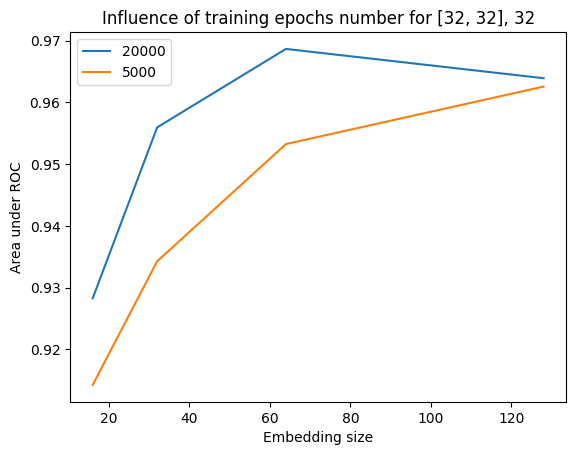

In [365]:
for N in GNN_results.n_epochs.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == "[32, 32]")
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == N)
    )
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.legend()
plt.title("Influence of training epochs number for [32, 32], 32")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

Text(0, 0.5, 'Area under ROC')

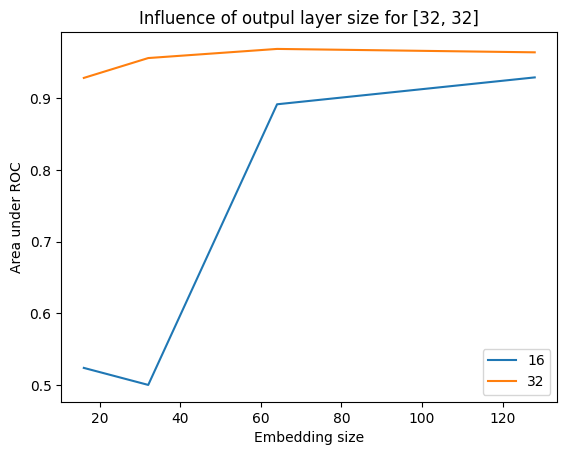

In [366]:
for N in GNN_results.out_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == "[32, 32]")
        & (GNN_results["out_size"] == N)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.legend()
plt.title("Influence of outpul layer size for [32, 32]")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

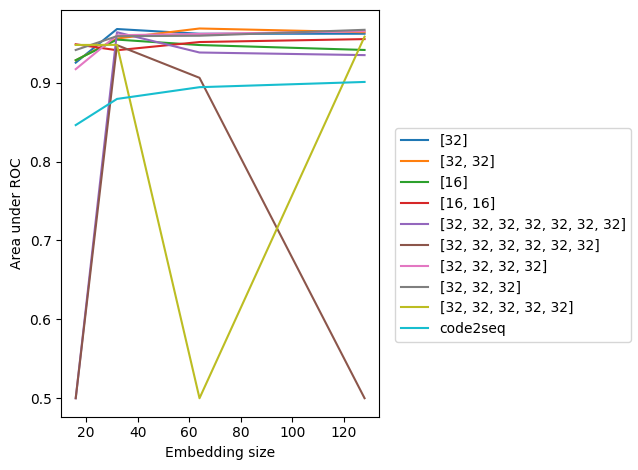

In [367]:
code2seq_results = code2seq_results.sort_values("embeddings_size")

fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=h,
    )
ax.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

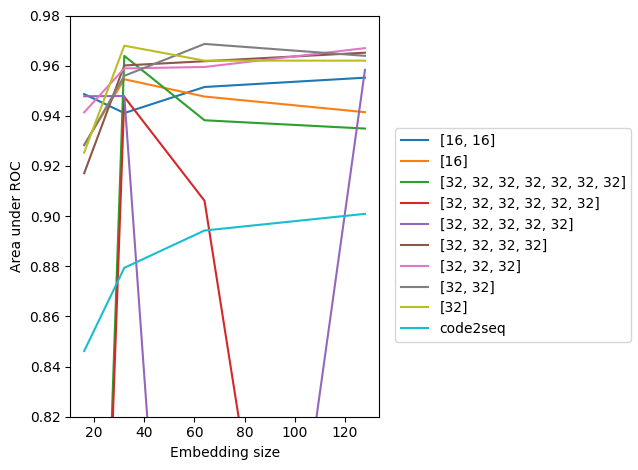

In [368]:
GNN_results = GNN_results.sort_values(["embeddings_size", "hidden_size"])
code2seq_results = code2seq_results.sort_values("embeddings_size")

fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=h,
    )
ax.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.82, 0.98)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

In [369]:
{h: "" for h in GNN_results.hidden_size.unique()}

{'[64, 64, 64]': '',
 '[64, 64]': '',
 '[16, 16]': '',
 '[16]': '',
 '[32, 32, 32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32]': '',
 '[32, 32, 32]': '',
 '[32, 32]': '',
 '[32]': '',
 '[64]': ''}

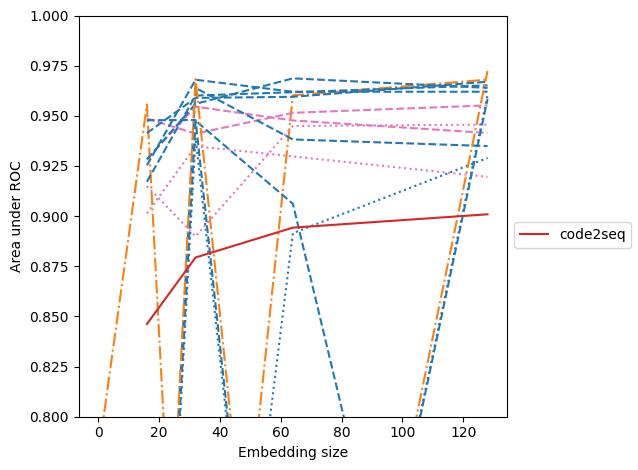

In [370]:
color_map = {
    "[64]": "tab:orange",
    "[64, 64, 64]": "tab:orange",
    "[64, 64]": "tab:orange",
    "[32, 32]": "tab:blue",
    "[32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32]": "tab:blue",
    "[16]": "tab:pink",
    "[16, 16]": "tab:pink",
    "[32]": "tab:blue",
    "[32, 32, 32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32, 32, 32, 32]": "tab:blue",
}
line_map = {
    16: "dotted",
    32: "dashed",
    64: "dashdot",
}

fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)

for h, o in itertools.product(
    GNN_results.hidden_size.unique(), GNN_results.out_size.unique()
):
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == o)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        # label=f"{h}, {o}",
        color=color_map[h],
        linestyle=line_map[o]
    )
plt.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
    color="tab:red",
    linestyle="solid",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.8,1.0)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

Text(0, 0.5, 'Area under ROC')

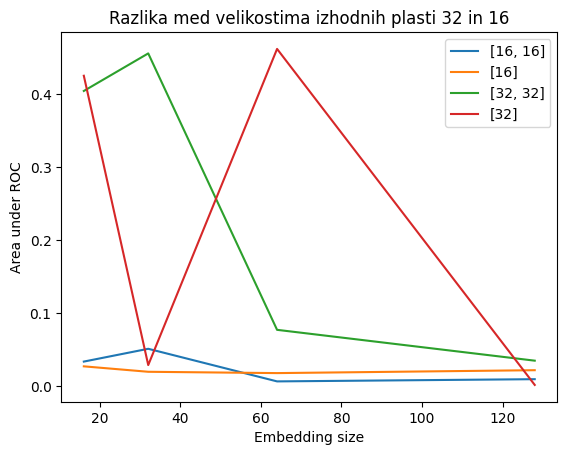

In [371]:

for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    criterion2 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty or GNN_results[criterion2].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"].array
        - GNN_results[criterion2]["area_under_roc"].array,
        label=h,
    )
plt.legend()
plt.title("Razlika med velikostima izhodnih plasti 32 in 16")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

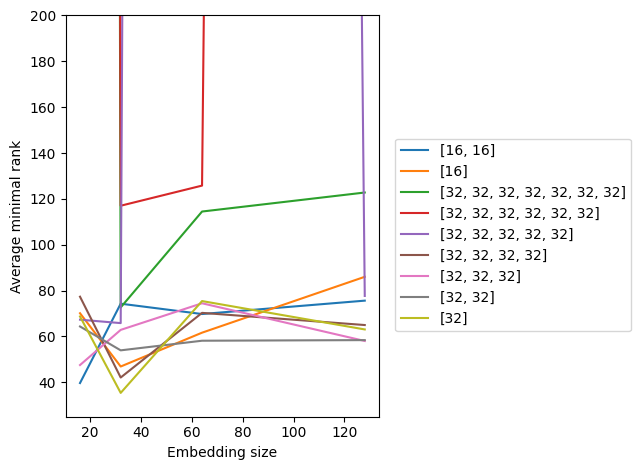

In [372]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal rank")
plt.ylim(25,200)
# ax.set_yscale('log')

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

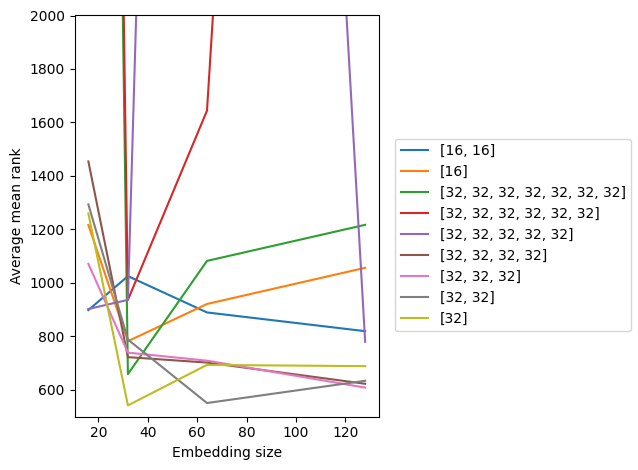

In [373]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean rank")
plt.ylim(500,2000)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

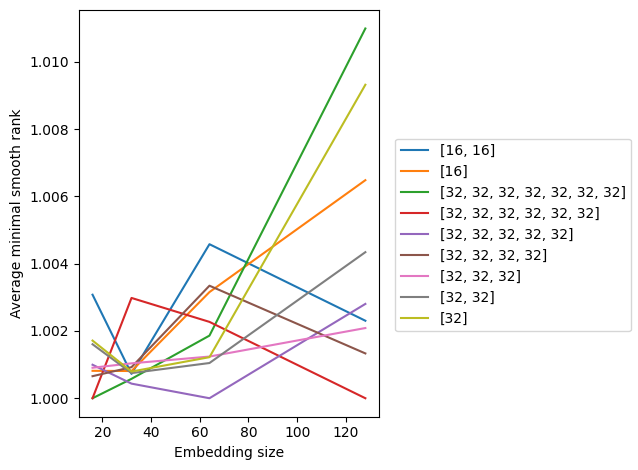

In [374]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

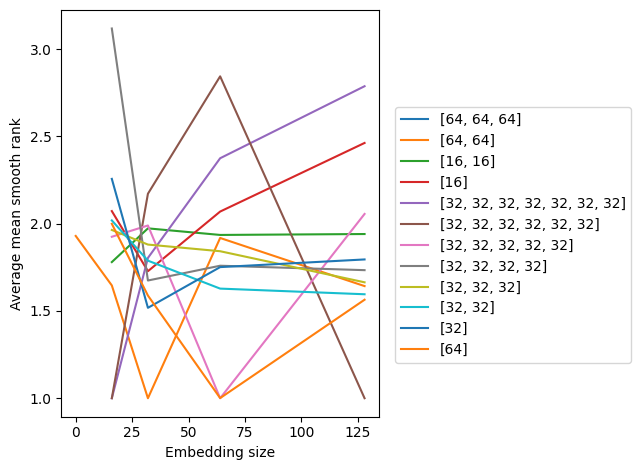

In [375]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] != 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_smooth_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

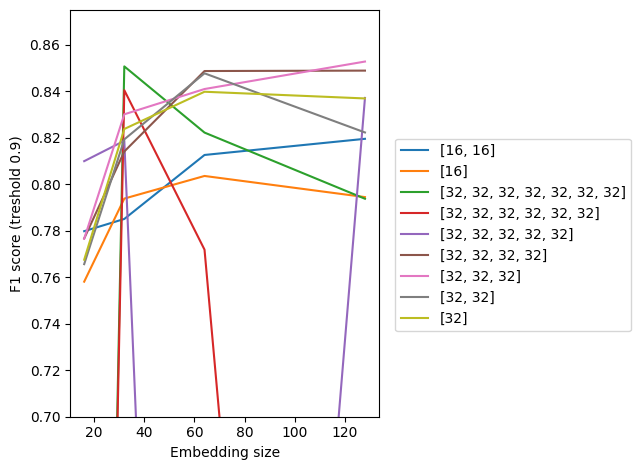

In [376]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["f1_0.9"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("F1 score (treshold 0.9)")
plt.ylim(0.7,0.875)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

Text(0, 0.5, 'Area under ROC')

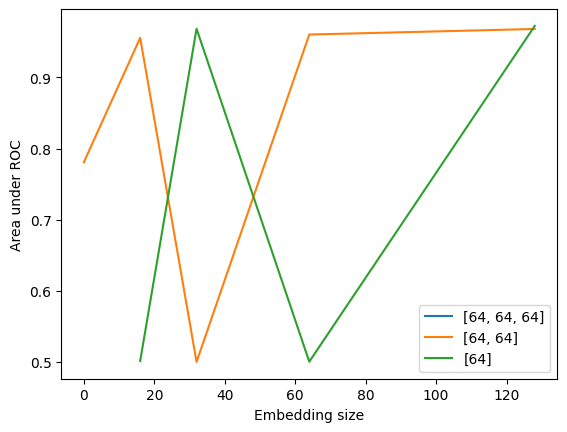

In [377]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

Text(0, 0.5, 'Average minimal rank')

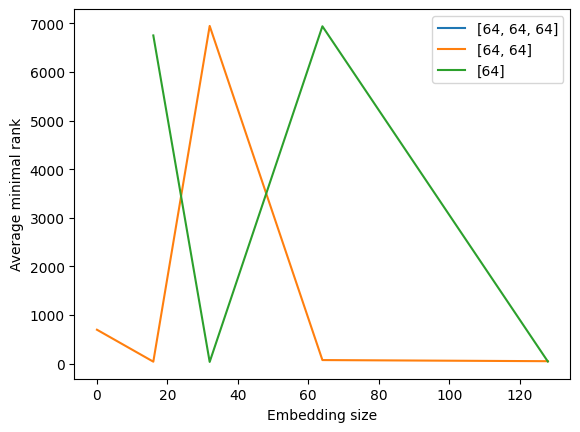

In [378]:

for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal rank")

Text(0, 0.5, 'Average mean rank')

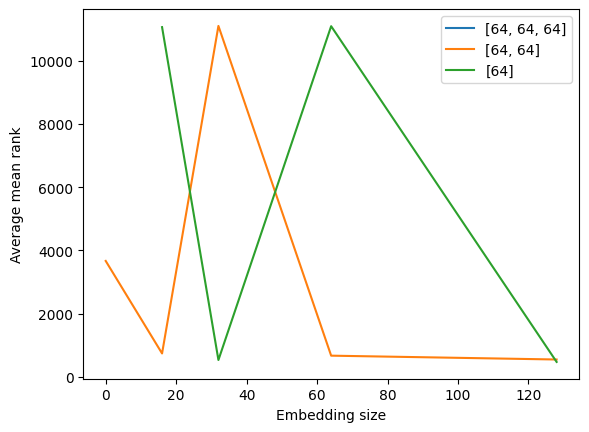

In [379]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean rank")

(1.0, 1.005)

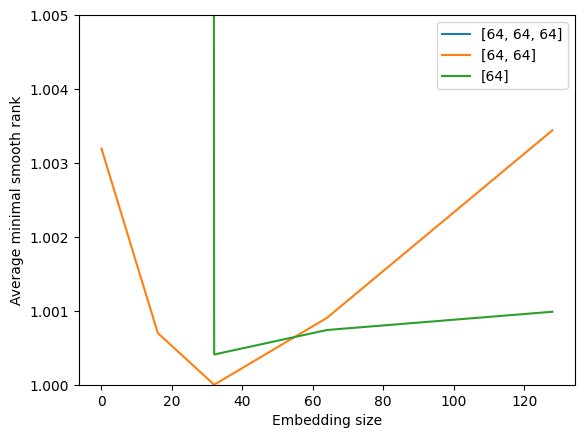

In [380]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal smooth rank")
plt.ylim(1.0, 1.005)

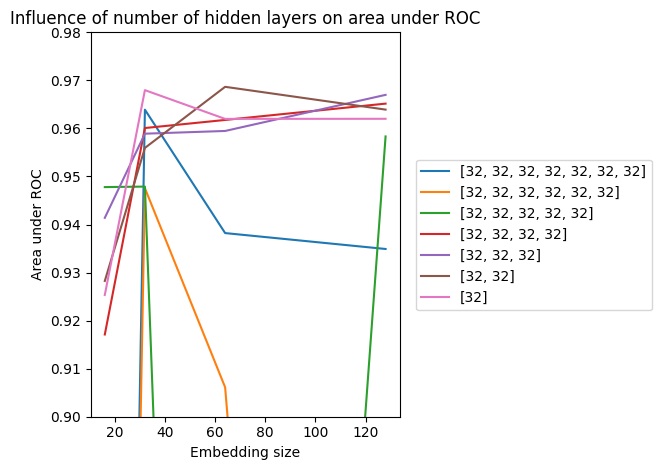

In [381]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.title("Influence of number of hidden layers on area under ROC")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.9,0.98)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

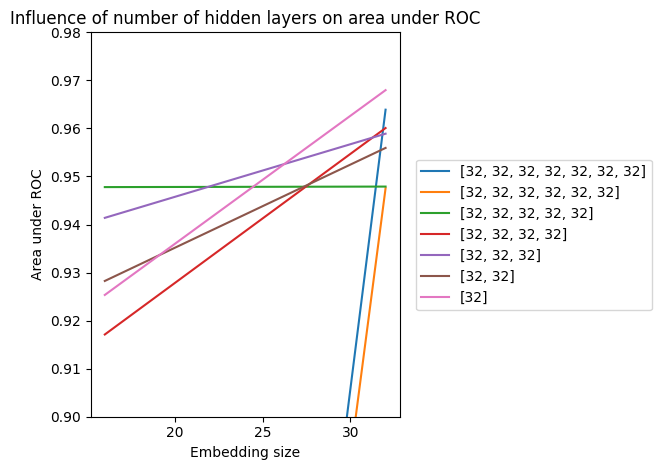

In [382]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
        & (GNN_results["embeddings_size"] <= 32)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.title("Influence of number of hidden layers on area under ROC")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.9,0.98)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

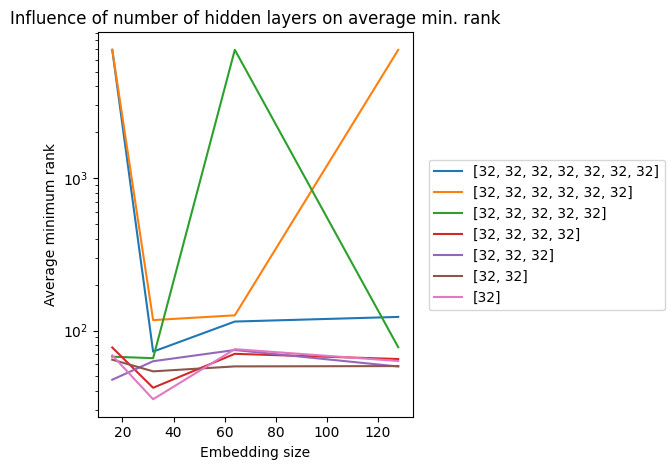

In [383]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_rank"],
        label=N,
    )
plt.title("Influence of number of hidden layers on average min. rank")
plt.xlabel("Embedding size")
plt.ylabel("Average minimum rank")
plt.yscale("log")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

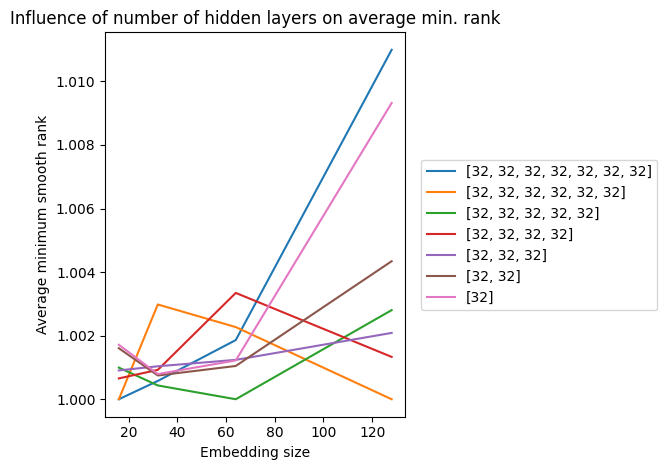

In [384]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=N,
    )
plt.title("Influence of number of hidden layers on average min. rank")
plt.xlabel("Embedding size")
plt.ylabel("Average minimum smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

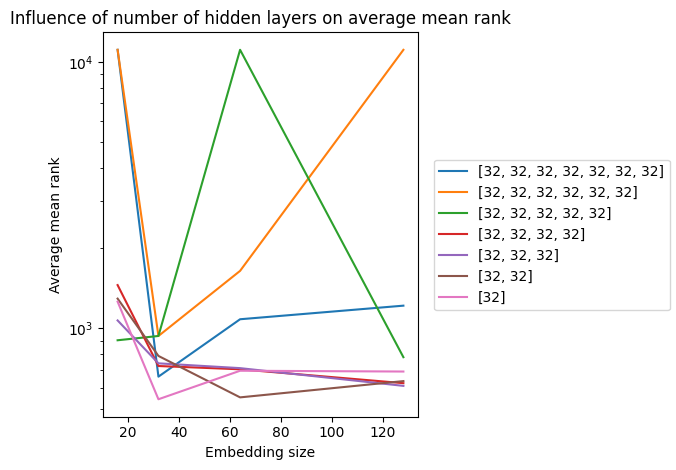

In [385]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_rank"],
        label=N,
    )
plt.title("Influence of number of hidden layers on average mean rank")
plt.xlabel("Embedding size")
plt.ylabel("Average mean rank")
plt.yscale("log")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

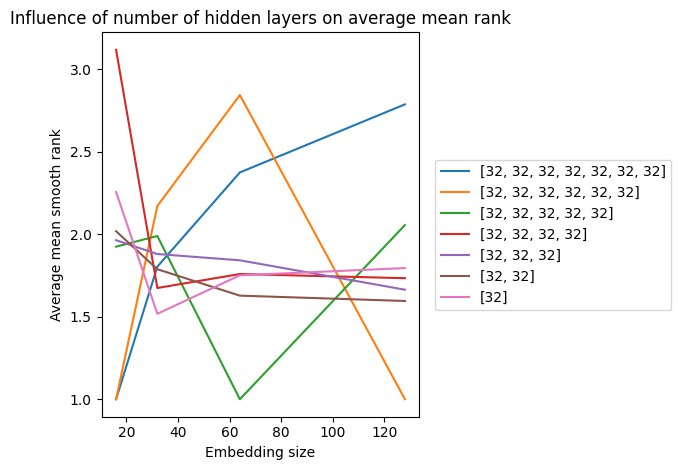

In [386]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_smooth_rank"],
        label=N,
    )

plt.title("Influence of number of hidden layers on average mean rank")
plt.xlabel("Embedding size")
plt.ylabel("Average mean smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

## F1 scores of chosen models 

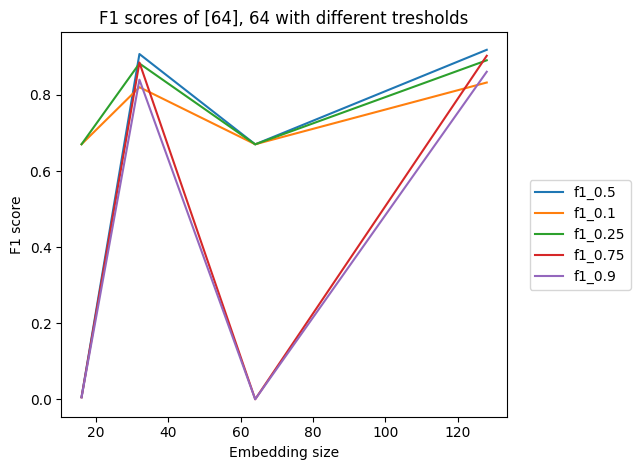

In [387]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[64]")
    & (GNN_results["out_size"] == 64)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [64], 64 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

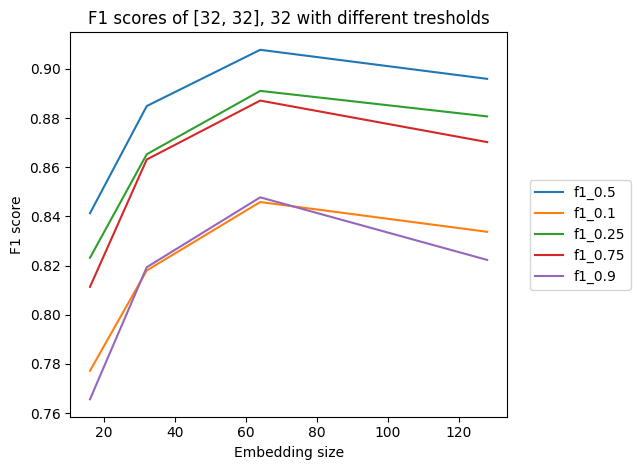

In [388]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[32, 32]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [32, 32], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

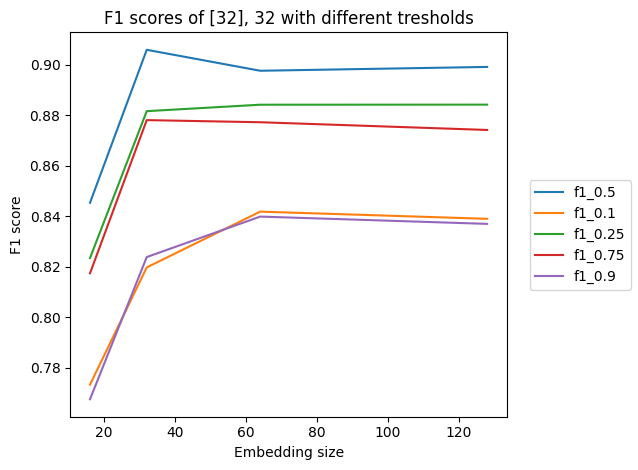

In [389]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[32]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [32], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

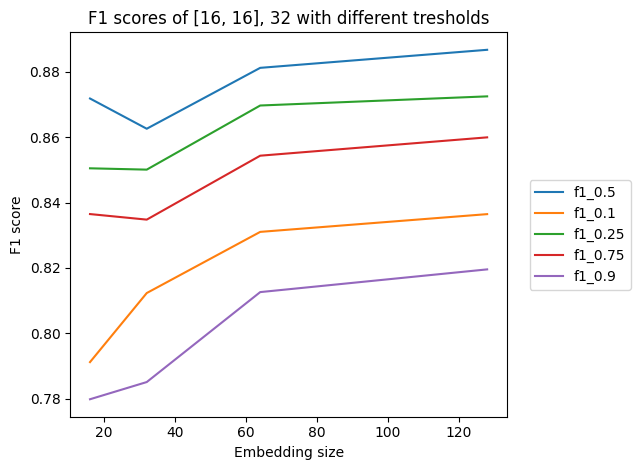

In [390]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[16, 16]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [16, 16], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()